In [56]:
import obspy
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.core.stream import Stream
import scipy.fftpack
import numpy as np
from scipy import signal
import pandas as pd
from scipy.stats import gmean
import math
import warnings
from obspy.signal.trigger import plot_trigger
from obspy.signal.trigger import classic_sta_lta
import fast_konno_ohmachi as fko

class preprocessing:
    def __init__(self, streamz):
        self.streamz = streamz
    
    def split(self):
        """
        Select each traces in stream then plot them
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.select.html
        documentation for details
        """
        channel_info = self.streamz[0].stats['channel']
        network = self.streamz[0].stats['network']
        station = self.streamz[0].stats['station']

        self.trace_z = self.streamz.select(channel = "*Z")[0]
        self.trace_n = self.streamz.select(channel = "*N")[0] 
        self.trace_e = self.streamz.select(channel = "*E")[0]
        
        self.dic = {"z": self.trace_z, "n": self.trace_n, "e": self.trace_e}
    
    def resamplez(self):
        """
        Resample each traces in stream.
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.resample.html
        documentation for details.
        
        new_sample = float
        """
        new_sample = float(input("Input Number of Samples: "))
        for v in self.dic.values():
            after_resample = v.resample(new_sample, window='hann', no_filter=True, strict_length=False)
            print(after_resample)
        else:
            pass
    
    def autotrim(self):
        """
        automatic trimming 
        stt -- starttime sorted ascending
        edt -- endtime sorted descending
        """
        time = [],[]
        for v in self.dic.values():
            time[0].append(v.stats.starttime)
            time[1].append(v.stats.endtime)
        starttime_aut = sorted(time[0],reverse = True)
        endtime_aut = sorted(time[1],reverse = False)
        print(starttime_aut)
        print(endtime_aut)
    
    def cek_input(self):
        """
        Perform checks on inputs.
        Specifically:
        1. Ensure all components have equal `dt`, if not resample.
        2. Ensure all components have same `nsamples`, if not trimm.
            
            ckin = cek input
        """
        #ckin = self.traces
        if self.trace_z.stats.delta != self.trace_n.stats.delta != self.trace_e.stats.delta:
            self.resamplez()
            msg = "All components must have equal `dt`, you must resample them"
            raise ValueError(msg)
        else:
            pass
        
        if self.trace_z.stats.npts != self.trace_n.stats.npts != self.trace_e.stats.npts:
            msg = f"All components are different length, you must trim them"
            raise ValueError(msg)
        else:
            pass
        
    def detrendz(self):
        """
        Detrend each traces in stream.
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.detrend.html
        documentation for details.
        """
        self.streamz = self.streamz.detrend('linear')
    
    def tpr(self):
        """
        Taper each traces in stream
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.taper.html
        documentation for details
        """
        self.streamz = self.streamz.taper(max_percentage=0.05, type='cosine')
        
    def filterz(self):
        """
        Filter each traces in stream
        Refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.filter.html
        documentation for details
        """
        self.streamz = self.streamz.filter('bandpass', freqmin=0.1, freqmax=0.2, zerophase=True)
        
    def plot_ts(self):
        """
        plot time series each traces in stream
        refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.plot.html
        doccumentation for details
        """
        self.streamz.plot()
        
class hvsr(preprocessing):

    def __init__(self, streamz, size):
        # class hvsr dihubungkan dengan class preprocessing dengan inheritance
        #self.trace_z = trace_z
        #self.trace_n = trace_x
        #self.trace_e = trace_y
        self.size = size
        preprocessing.__init__(self, streamz)
        
    def normalisasi_td(self):
        """
        By default all traces are normalized separately to their respective absolute maximum. 
        By setting global_max=True all traces get normalized to the global maximum of all traces.
        refer to https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.normalize.html
        """
        self.streamz.normalize(global_max = False)
    
    def trigger_sta_lta(self):
        """
        trigger each traces in stream
        Refer to https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html
        documentation for details
        """
        for v in self.dic.values():
            df = v.stats.sampling_rate
            cft = classic_sta_lta(v.data, int(5 * df), int(10 * df))
            plot_trigger(v, cft, 1.5, 0.5)

In [57]:
from obspy import read
file_path = 'UT.STN11.A2_C50.miniseed'
st = read(file_path)
e = hvsr(st, 60)
e.split()
e.cek_input()
e.autotrim()
e.resamplez()

[UTCDateTime(2017, 5, 4, 5, 30), UTCDateTime(2017, 5, 4, 5, 30), UTCDateTime(2017, 5, 4, 5, 30)]
[UTCDateTime(2017, 5, 4, 6, 0), UTCDateTime(2017, 5, 4, 6, 0), UTCDateTime(2017, 5, 4, 6, 0)]


UT.STN11..BHZ | 2017-05-04T05:30:00.000000Z - 2017-05-04T05:59:59.975000Z | 40.0 Hz, 72000 samples
UT.STN11..BHN | 2017-05-04T05:30:00.000000Z - 2017-05-04T05:59:59.975000Z | 40.0 Hz, 72000 samples
UT.STN11..BHE | 2017-05-04T05:30:00.000000Z - 2017-05-04T05:59:59.975000Z | 40.0 Hz, 72000 samples


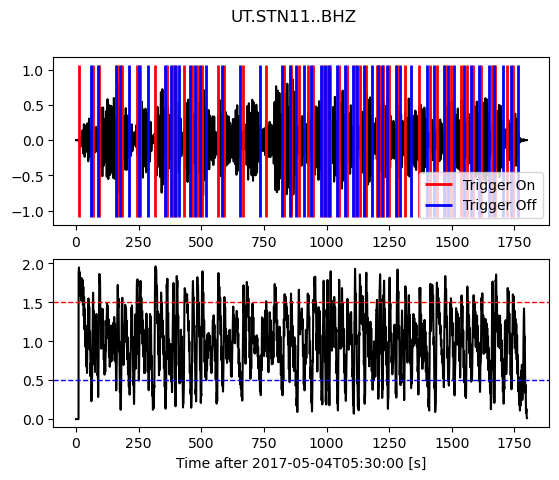

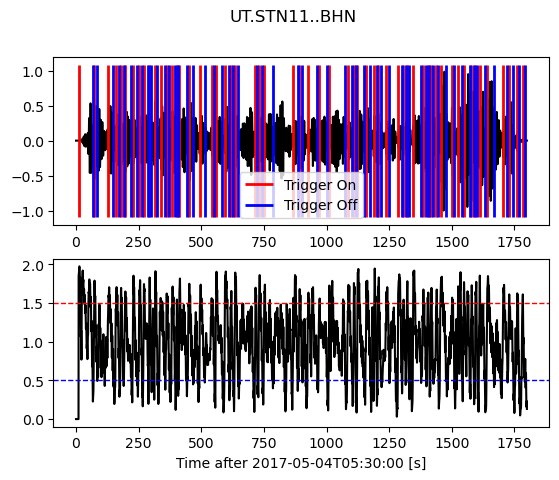

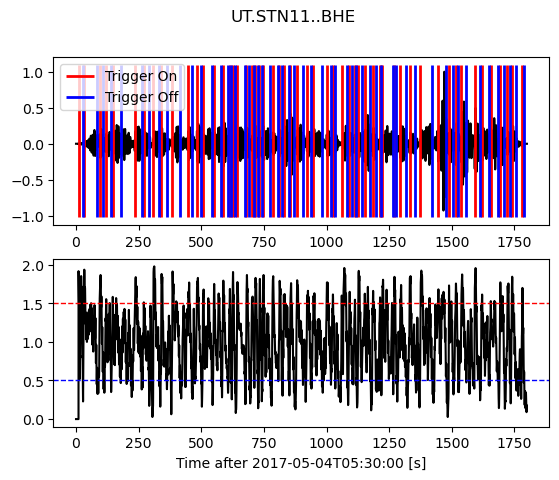

In [ ]:
e.detrendz()
e.tpr()
e.filterz()
e.normalisasi_td()
#e.plot_ts()
e.trigger_sta_lta()

In [37]:
str = "T2"
a = int(str)
print(a)


ValueError: invalid literal for int() with base 10: 'T2'